# Replication code for "Evaluating interdisciplinary research"

In [1]:
library(dplyr, quietly = TRUE)
library(ggplot2)
library(grid)
library(gridExtra)
library(gtools)
library(margins)
library(marginaleffects)
library(scales)
library(stargazer, quietly = TRUE)
library(tidyr, quietly = TRUE)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




In [2]:
# Reading in data
# Note that for anonymization purposes, interdisciplinarity measures are standardized with normally distributed noise,
# 1% of binary outcomes are flipped, and covariates are deciled.

subs_df <- read.csv("subs_anon.csv")  # Submissions
revs_df <- read.csv("revs_anon.csv")  # Reviews

## Table 1: Descriptive statistics & correlations

In [3]:
summary(subs_df)

 manuscript_id        journal          journal_type       manuscript_type   
 Length:128950      Length:128950      Length:128950      Length:128950     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
     year           topic_interdis        kb_interdis         teamsize_decile
 Length:128950      Min.   :-1.8848686   Min.   :-3.1175638   Min.   :1.000  
 Class :character   1st Qu.:-0.8816614   1st Qu.:-0.6225747   1st Qu.:3.000  
 Mode  :character   Median : 0.1848160   Median : 0.1279247   Median :4.000  
                    Mean   :-0.0005932   Mean   :-0.0002057   Mean   :4.

In [4]:
subs_df %>%
    select(topic_interdis, kb_interdis, teamsize_decile, maxcites_decile, numrefs_decile, prevpubs_decile) %>%
    drop_na() %>%
    cor()

,topic_interdis,kb_interdis,teamsize_decile,maxcites_decile,numrefs_decile,prevpubs_decile
topic_interdis,1.000000000,0.55852938,0.02478083,0.01140542,-0.03093581,0.005652783
kb_interdis,0.558529375,1.00000000,0.08214913,0.04290303,0.03485410,0.026425885
teamsize_decile,0.024780825,0.08214913,1.00000000,0.47702905,0.14290800,0.473004859
maxcites_decile,0.011405415,0.04290303,0.47702905,1.00000000,0.13182945,0.939689999
numrefs_decile,-0.030935807,0.03485410,0.14290800,0.13182945,1.00000000,0.085115461
prevpubs_decile,0.005652783,0.02642589,0.47300486,0.93969000,0.08511546,1.000000000


## Table 2: Logistic regression, final decision

In [5]:
mod1 <- glm(final_decision ~ topic_interdis,
    family = binomial(link="logit"),
    data=subs_df)
mod2 <- glm(final_decision ~ kb_interdis,
    family = binomial(link="logit"),
    data=subs_df)
mod3 <- glm(final_decision ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=subs_df)
mod4 <- glm(final_decision ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=subs_df)
mod5 <- glm(final_decision ~ topic_interdis + kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=subs_df)
mod6 <- glm(final_decision ~ topic_interdis*kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=subs_df)

stargazer(mod1,mod2,mod3,mod4,mod5,mod6,
          type = "text",
          title="Logistic regression: Final decision",
          align = TRUE,
          dep.var.labels = c("Final decision"),
          no.space = TRUE,
          omit = c("journal", "manuscript_type", "as.factor.year", "as.factor.teamsize_decile", "as.factor.maxcites_decile", "as.factor.numrefs_decile", "as.factor.prevpubs_decile"),
          covariate.labels = c("Constant","Topic ID", "Knowledgebase ID", "Topic ID:Knowledgebase ID"),
          intercept.bottom = FALSE,
          digits = 3,
          digits.extra = 0)

# Saving coefficients to plot
fd_coef_3 <- coef(mod3)["topic_interdis"]
fd_stderr_3 <- summary(mod3)$coef["topic_interdis", "Std. Error"]
fd_coef_4 <- coef(mod4)["kb_interdis"]
fd_stderr_4 <- summary(mod4)$coef["kb_interdis", "Std. Error"]


Logistic regression: Final decision
                                                    Dependent variable:                          
                          -----------------------------------------------------------------------
                                                      Final decision                             
                              (1)         (2)         (3)         (4)         (5)         (6)    
-------------------------------------------------------------------------------------------------
Constant                   0.142***    0.142***    3.138***    3.037***    3.060***    3.020***  
                            (0.006)     (0.006)     (1.014)     (1.014)     (1.014)     (1.014)  
Topic ID                   -0.040***               -0.055***               -0.092***   -0.094*** 
                            (0.006)                 (0.007)                 (0.007)     (0.007)  
Knowledgebase ID                       0.018***                0.039***    0.085*

In [6]:
margins_topic <- margins(mod3, variables = "topic_interdis")
print(summary(margins_topic))
margins_kb <- margins(mod4, variables = "kb_interdis")
print(summary(margins_kb))

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misl

         factor     AME SE  z  p lower upper
 topic_interdis -0.0119 NA NA NA    NA    NA


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misl

      factor    AME SE  z  p lower upper
 kb_interdis 0.0084 NA NA NA    NA    NA


## Table 3: Logistic regression, review positivity

In [7]:
mod1 <- glm(review_positivity ~ topic_interdis,
    family = binomial(link="logit"),
    data=revs_df)
mod2 <- glm(review_positivity ~ kb_interdis,
    family = binomial(link="logit"),
    data=revs_df)
mod3 <- glm(review_positivity ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=revs_df)
mod4 <- glm(review_positivity ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=revs_df)
mod5 <- glm(review_positivity ~ topic_interdis + kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=revs_df)
mod6 <- glm(review_positivity ~ topic_interdis*kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=revs_df)

stargazer(mod1,mod2,mod3,mod4,mod5,mod6, 
          apply.coef = exp, # Uncomment for ORs
          ci = TRUE,  # Uncomment for ORs (have to use CIs b/c SEs will be incorrect)
          type = "text",
          title="Logistic regression: Review positivity",
          align = TRUE,
          dep.var.labels = c("Review positivity"),
          no.space = TRUE,
          omit = c("journal", "manuscript_type", "as.factor.year", "as.factor.teamsize_decile", "as.factor.maxcites_decile", "as.factor.numrefs_decile", "as.factor.prevpubs_decile"),
          covariate.labels = c("Constant","Topic ID", "Knowledgebase ID", "Topic ID:Knowledgebase ID"),
          intercept.bottom = FALSE,
          digits = 3,
          digits.extra = 0)

# Saving coefficients to plot
rp_coef_3 <- coef(mod3)["topic_interdis"]
rp_stderr_3 <- summary(mod3)$coef["topic_interdis", "Std. Error"]
rp_coef_4 <- coef(mod4)["kb_interdis"]
rp_stderr_4 <- summary(mod4)$coef["kb_interdis", "Std. Error"]


Logistic regression: Review positivity
                                                                 Dependent variable:                                       
                          -------------------------------------------------------------------------------------------------
                                                                  Review positivity                                        
                               (1)            (2)             (3)              (4)              (5)              (6)       
---------------------------------------------------------------------------------------------------------------------------
Constant                     3.866***       3.869***       17.451***        16.066***        16.344***        16.003***    
                          (3.855, 3.877) (3.858, 3.880) (16.705, 18.197) (15.320, 16.812) (15.598, 17.090) (15.257, 16.749)
Topic ID                     0.990***                       0.976***                        

## Figure 1: Interdisciplinarity vs. review outcomes

In [8]:
# Monodisciplinary and interdisciplinary journal models
mono_subs_df <- subset(subs_df, journal_type == "Monodisciplinary")
interdis_subs_df <- subset(subs_df, journal_type == "Interdisciplinary")
mono_revs_df <- subset(revs_df, journal_type == "Monodisciplinary")
interdis_revs_df <- subset(revs_df, journal_type == "Interdisciplinary")

mod_mono_3_fd <- glm(final_decision ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=mono_subs_df)

mod_mono_3_rp <- glm(review_positivity ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=mono_revs_df)

mod_mono_4_fd <- glm(final_decision ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=mono_subs_df)

mod_mono_4_rp <- glm(review_positivity ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=mono_revs_df)

mod_interdis_3_fd <- glm(final_decision ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=interdis_subs_df)

mod_interdis_3_rp <- glm(review_positivity ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=interdis_revs_df)

mod_interdis_4_fd <- glm(final_decision ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=interdis_subs_df)

mod_interdis_4_rp <- glm(review_positivity ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=interdis_revs_df)

mono_3_fd_coef <- coef(mod_mono_3_fd)["topic_interdis"]
mono_3_rp_coef <- coef(mod_mono_3_rp)["topic_interdis"]
mono_4_fd_coef <- coef(mod_mono_4_fd)["kb_interdis"]
mono_4_rp_coef <- coef(mod_mono_4_rp)["kb_interdis"]
interdis_3_fd_coef <- coef(mod_interdis_3_fd)["topic_interdis"]
interdis_3_rp_coef <- coef(mod_interdis_3_rp)["topic_interdis"]
interdis_4_fd_coef <- coef(mod_interdis_4_fd)["kb_interdis"]
interdis_4_rp_coef <- coef(mod_interdis_4_rp)["kb_interdis"]

mono_3_fd_stderr <- summary(mod_mono_3_fd)$coef["topic_interdis", "Std. Error"]
mono_3_rp_stderr <- summary(mod_mono_3_rp)$coef["topic_interdis", "Std. Error"]
mono_4_fd_stderr <- summary(mod_mono_4_fd)$coef["kb_interdis", "Std. Error"]
mono_4_rp_stderr <- summary(mod_mono_4_rp)$coef["kb_interdis", "Std. Error"]
interdis_3_fd_stderr <- summary(mod_interdis_3_fd)$coef["topic_interdis", "Std. Error"]
interdis_3_rp_stderr <- summary(mod_interdis_3_rp)$coef["topic_interdis", "Std. Error"]
interdis_4_fd_stderr <- summary(mod_interdis_4_fd)$coef["kb_interdis", "Std. Error"]
interdis_4_rp_stderr <- summary(mod_interdis_4_rp)$coef["kb_interdis", "Std. Error"]

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


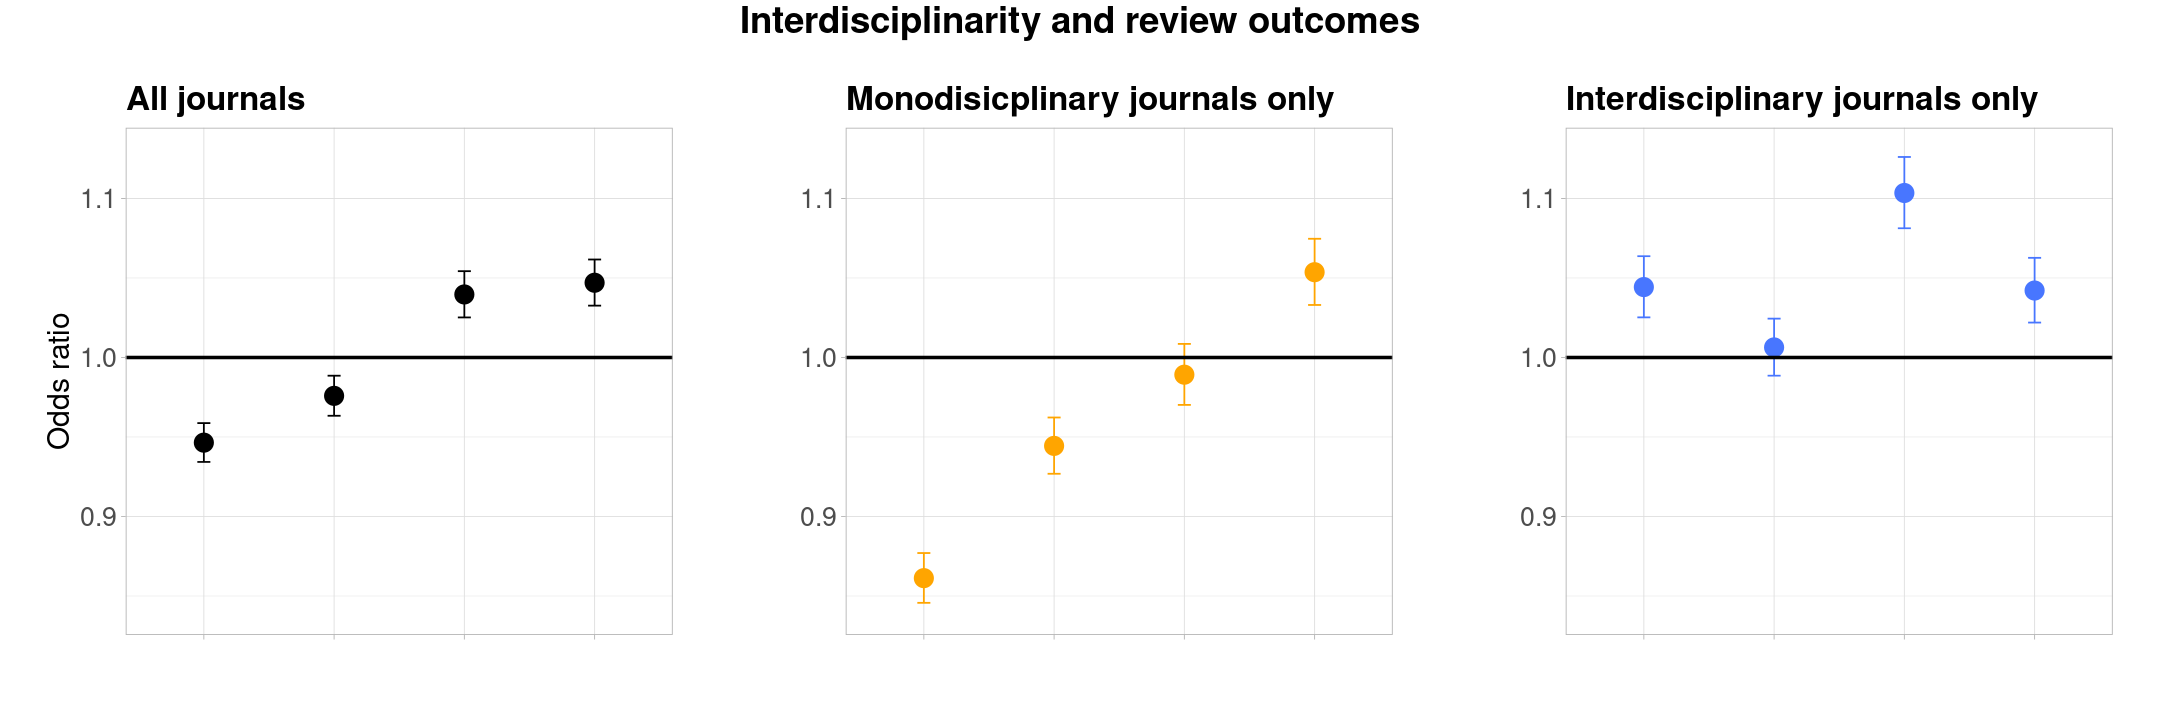

In [9]:
# Create dfs for plotting
coef_df <- data.frame(
    model = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"),
    coefficient = c(fd_coef_3, rp_coef_3, fd_coef_4, rp_coef_4),
    odds_ratio = exp(c(fd_coef_3, rp_coef_3, fd_coef_4, rp_coef_4)),
    error = c(fd_stderr_3, rp_stderr_3, fd_stderr_4, rp_stderr_4),
    journals = "All"
)
coef_df$model <- factor(coef_df$model, levels = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"))

coef_df_mono <- data.frame(
    model = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"),
    coefficient = c(mono_3_fd_coef, mono_3_rp_coef, mono_4_fd_coef, mono_4_rp_coef),
    odds_ratio = exp(c(mono_3_fd_coef, mono_3_rp_coef, mono_4_fd_coef, mono_4_rp_coef)),
    error = c(mono_3_fd_stderr, mono_3_rp_stderr, mono_4_fd_stderr, mono_4_rp_stderr),
    journals = "Monodisciplinary"
)
coef_df_mono$model <- factor(coef_df_mono$model, levels = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"))

coef_df_int <- data.frame(
    model = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"),
    coefficient = c(interdis_3_fd_coef, interdis_3_rp_coef, interdis_4_fd_coef, interdis_4_rp_coef),
    odds_ratio = exp(c(interdis_3_fd_coef, interdis_3_rp_coef, interdis_4_fd_coef, interdis_4_rp_coef)),
    error = c(interdis_3_fd_stderr, interdis_3_rp_stderr, interdis_4_fd_stderr, interdis_4_rp_stderr),
    journals = "Interdisciplinary"
)
coef_df_int$model <- factor(coef_df_int$model, levels = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"))


# Plotting
ymin <- 0.84
ymax <- 1.13

options(repr.plot.width = 18,repr.plot.height = 6)

plot1 <- ggplot(data=coef_df, aes(x=model, y=odds_ratio)) + 
    geom_point(size=5, color="black") +
    geom_errorbar(aes(ymin=exp(coefficient - (1.96*error)), max = exp(coefficient + (1.96*error))), width = 0.1, color="black") +
    geom_hline(yintercept = 1, color = "black", size = 1) +
    ylim(ymin, ymax) +
    labs(title = "All journals",
         x = "",
         y= "Odds ratio") +
    theme_light() +
    theme(#axis.text.x = element_text(angle = 30, hjust = 1, size = 16),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.text = element_text(size = 14),
          legend.title = element_text(size = 14),
          plot.title = element_text(size = 20, face = "bold"),
          plot.margin = unit(c(1, 1, 1, 1), "cm")
    )

plot2 <- ggplot(data=coef_df_mono, aes(x=model, y=odds_ratio)) + 
    geom_point(size=5, color="orange1") +
    geom_errorbar(aes(ymin=exp(coefficient - (1.96*error)), max = exp(coefficient + (1.96*error))), width = 0.1, color="orange1") +
    geom_hline(yintercept = 1, color = "black", size = 1) +
    ylim(ymin, ymax) +
    labs(title = "Monodisicplinary journals only",
         x = "",
         y= "") +
    theme_light() +
    theme(#axis.text.x = element_text(angle = 30, hjust = 1, size = 16),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.text = element_text(size = 14),
          legend.title = element_text(size = 14),
          plot.title = element_text(size = 20, face = "bold"),
          plot.margin = unit(c(1, 1, 1, 1), "cm")
    )

plot3 <- ggplot(data=coef_df_int, aes(x=model, y=odds_ratio)) + 
    geom_point(size=5, color="royalblue1") +
    geom_errorbar(aes(ymin=exp(coefficient - (1.96*error)), max = exp(coefficient + (1.96*error))), width = 0.1, color="royalblue1") +
    geom_hline(yintercept = 1, color = "black", size = 1) +
    ylim(ymin, ymax) +
    labs(title = "Interdisciplinary journals only",
         x = "",
         y= "") +
    theme_light() +
    theme(#axis.text.x = element_text(angle = 30, hjust = 1, size = 16),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.text = element_text(size = 14),
          legend.title = element_text(size = 14),
          plot.title = element_text(size = 20, face = "bold"),
          plot.margin = unit(c(1, 1, 1, 1), "cm")
    )

g <- arrangeGrob(plot1, plot2, plot3, ncol=3,
            top=textGrob("Interdisciplinarity and review outcomes",
                         gp=gpar(fontsize=22,
                                 fontface="bold")))

grid.draw(g)

## Figure 2: Interaction

In [10]:
mod6 <- glm(final_decision ~ topic_interdis*kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_decile) + as.factor(maxcites_decile) + as.factor(numrefs_decile) + as.factor(prevpubs_decile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=subs_df)

p1 <- plot_predictions(mod6,
                       condition=list('topic_interdis',
                                   'kb_interdis' = 'threenum'),
                       draw = FALSE)
p2 <- plot_predictions(mod6,
                       condition=list('kb_interdis',
                                   'topic_interdis' = 'threenum'),
                       draw = FALSE)

Warning message:
“Model matrix is rank deficient. Some variance-covariance parameters are
  missing.”
Warning message:
“Model matrix is rank deficient. Some variance-covariance parameters are
  missing.”


Scale for linetype is already present.
Adding another scale for linetype, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for linetype is already present.
Adding another scale for linetype, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 30 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 57 rows containing missing values (`geom_line()`).”


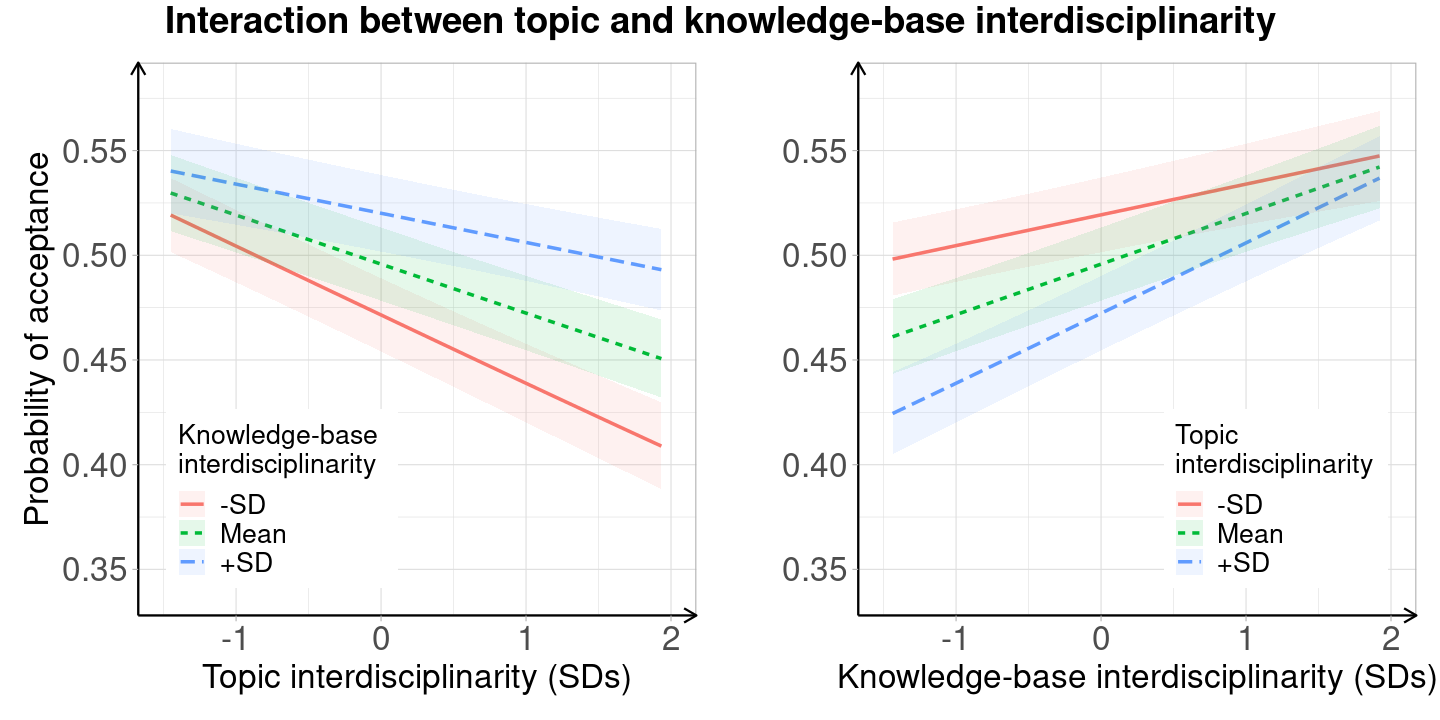

In [11]:
# Plotting

labels <- c('-SD', 'Mean', '+SD')
options(repr.plot.width=12, repr.plot.height=6)

ylims <- c(0.34, 0.58)
breaks <- seq(0.35, 0.55, 0.05)
xlims <- c(-1.5, 2)

# KBID as line
plot1 <- ggplot(p1, aes(x = topic_interdis, y = estimate,
            linetype = kb_interdis, color = kb_interdis, fill = kb_interdis)) +
            geom_line(size = 1) +
            #scale_linetype_manual(values = c("solid", "dashed", "dotted", "dotdash", "longdash")) +
            scale_linetype_manual(values = c("solid", "dashed", "dotted")) +
            #scale_color_manual(values = hue_pal()(5)) +
            scale_color_manual(values = hue_pal()(3)) +
            geom_ribbon(aes(ymin = conf.low, ymax = conf.high), alpha = 0.1, color = NA) +
            #scale_fill_manual(values = hue_pal()(5)) +
            scale_fill_manual(values = hue_pal()(3)) +
            scale_linetype_discrete(labels = labels) +
            scale_color_discrete(labels = labels) +
            scale_fill_discrete(labels = labels) +
            scale_y_continuous(limits=ylims, breaks=breaks) +
            scale_x_continuous(limits=xlims) +
            theme_light(base_size = 14) +
            labs(
                  #title = "Predicted probabilities of acceptance",
                  #title = "Predicted probabilities of positive review",
                  x = "Topic interdisciplinarity (SDs)",
                  y = "Probability of acceptance",
                  #y = "Probability of positive review",
                  linetype = "Knowledge-base \ninterdisciplinarity",
                  color = "Knowledge-base \ninterdisciplinarity",
                  fill = "Knowledge-base \ninterdisciplinarity") +
            theme(axis.line.x = element_line(arrow = grid::arrow(length = unit(0.3, "cm"), ends = "last")),
                  axis.line.y = element_line(arrow = grid::arrow(length = unit(0.3, "cm"), ends = "last")),
                  axis.text.x = element_text(size = 20),
                  axis.text.y = element_text(size = 20),
                  axis.title = element_text(size = 20),
                  legend.text = element_text(size = 16),
                  legend.title = element_text(size = 16),
                  legend.position = c(0.05, 0.05),
                  legend.justification = c("left", "bottom"),
                  plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"))

# TopID as line
plot2 <- ggplot(p2, aes(x = kb_interdis, y = estimate,
            linetype = topic_interdis, color = topic_interdis, fill = topic_interdis)) +
            geom_line(size = 1) +
            #scale_linetype_manual(values = c("solid", "dashed", "dotted", "dotdash", "longdash")) +
            scale_linetype_manual(values = c("solid", "dashed", "dotted")) +
            #scale_color_manual(values = hue_pal()(5)) +
            scale_color_manual(values = hue_pal()(3)) +
            geom_ribbon(aes(ymin = conf.low, ymax = conf.high), alpha = 0.1, color = NA) +
            #scale_fill_manual(values = hue_pal()(5)) +
            scale_fill_manual(values = hue_pal()(3)) +
            scale_linetype_discrete(labels = labels) +
            scale_color_discrete(labels = labels) +
            scale_fill_discrete(labels = labels) +
            scale_y_continuous(limits=ylims, breaks=breaks) +
            scale_x_continuous(limits=xlims) +
            theme_light(base_size = 14) +
            labs(
                  #title = "Predicted probabilities of acceptance",
                  #title = "Predicted probabilities of positive review",
                  x = "Knowledge-base interdisciplinarity (SDs)",
                  y = "",
                  #y = "Probability of positive review",
                  linetype = "Topic \ninterdisciplinarity",
                  color = "Topic \ninterdisciplinarity",
                  fill = "Topic \ninterdisciplinarity") +
            theme(axis.line.x = element_line(arrow = grid::arrow(length = unit(0.3, "cm"), ends = "last")),
                  axis.line.y = element_line(arrow = grid::arrow(length = unit(0.3, "cm"), ends = "last")),
                  axis.text.x = element_text(size = 20),
                  axis.text.y = element_text(size = 20),
                  axis.title = element_text(size = 20),
                  legend.text = element_text(size = 16),
                  legend.title = element_text(size = 16),
                  legend.position = c(0.95, 0.05),
                  legend.justification = c("right", "bottom"),
                  plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"))

g <- arrangeGrob(plot1, plot2,
                 ncol=2,
                 top=textGrob("Interaction between topic and knowledge-base interdisciplinarity",
                             gp=gpar(fontsize=22,
                                     fontface="bold")))

grid.draw(g)